# Mutual Information Test Cases
This notebook is an extension of the pytest file used in TDD. It shows the results of two main functions in the library
- get_entropy
- get_mutual_information_mixed

MAIN PENDING QUESTION - WHY I(X,X) is different from H(X) in the case of get_mutual_information_mixed

In [2]:
# importing same libraries
import numpy as np
from scipy.special import gamma, digamma
from scipy.spatial import KDTree
from scipy.stats import norm

In [1]:
# importing libraries to visualize results
import pylab as plt
import seaborn as sns

## Functions 

In [7]:
def get_log_volume_ball_d_p(D, d, p):
    """
    Computes the log of the volume of a d-ball of diameter D, (d - dimension) in a p-InformationTheoryMetricsLib
    Reference: https://en.wikipedia.org/wiki/Volume_of_an_n-ball#Balls_in_Lp_norms
    NOTE: KSG definition of a unit ball MIGHT be diameter = 1.
    Parameters:
    D:  scalar
        diameter
    d:  scalar
        dimension
    p:  scalar
        p-norm value
    Returns:
    log_vol:    scalar
                logarithm of the d-ball, p-norm of diameter D
    """
    return d*np.log(gamma(1./p + 1)) + d*np.log(D) - np.log(gamma(1.*d/p + 1))

In [3]:
def get_entropy_continuous(x,p=2,k=1):
    """
    Computes the estimated entropy for a continuous distribution following the
    Kraskov, Stogbauer and Grassberger (KSG) method (PhysRevE.69.066138 - 2014)
    Reference: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
    Equation 20
    Parameters:
    x:  array-like
        points in the distribution
    p:  scalar (p>=1)
        p value of the p-norm.
            p = 1, Manhattan
            p = 2, Eucledian
            p = np.inf, Max
    k:  scalar
        k neighbor
    Returns:
    h:  scalar
        Approximated entropy for the distribution
    """

    if len(x.shape) == 2:
        n, d = x.shape
    else:
        raise Exception("Input data set should be a 2-dimensional array")

    if p>=1:
        log_c_d_p = get_log_volume_ball_d_p(1, d, p)
    else:
        #raise Exception("Input p must be p>=1")
        return('Nope')

    tree = KDTree(x)
    all_distances, indices = tree.query(x, k + 1, p=p)
    distances_to_k_neighbor = all_distances[:,-1]

    sum_log_distances_to_k_neighbor = np.sum(np.log(2*distances_to_k_neighbor))
    h = -digamma(k) + digamma(n) + log_c_d_p + (1.*d/n) * sum_log_distances_to_k_neighbor

    return(h)

In [4]:
def get_mutual_information_mixed(x,y,p=2,k=1):
    """
    Computes the estimated mutual information for two mixed distributions following the
    Gao et al (2017)
    Reference: https://proceedings.neurips.cc/paper/2017/file/ef72d53990bc4805684c9b61fa64a102-Paper.pdf
    Algorithm 1
    Parameters:
    x:  array-like
        points in the distribution, continous or discrete
    y:  array-like
        points in the distribution, continous or discrete
    p:  scalar (p>=1)
        p value of the p-norm.
            p = 1, Manhattan
            p = 2, Eucledian
            p = np.inf, Max
    k:  scalar
        k neighbor
    Returns:
    mi:  scalar
        Approximated mutual information for the two distributions
    """

    # NOTE: do x,y need to be the same size?

    if len(x.shape) == 2 and len(y.shape) == 2 and x.shape == y.shape:
        n, d = x.shape
    else:
        raise Exception("Input data set should be a 2-dimensional array and same shape")

    if p>=1:
        log_c_d_p = True #get_log_volume_ball_d_p(1, d, p)
    else:
        #raise Exception("Input p must be p>=1")
        return('Nope')

    xy = np.c_[x,y]

    tree_x = KDTree(x)
    tree_y = KDTree(y)
    tree_xy = KDTree(xy)

    all_distances, indices = tree_xy.query(xy, k + 1, p=p)
    radii = all_distances[:,-1]

    lnx = np.zeros(n)
    lny = np.zeros(n)
    lk = np.zeros(n)

    for i_dim in range(n):
        if radii[i_dim] == 0:
            lk[i_dim] = len(tree_xy.query_ball_point(tree_xy.data[i_dim], r=radii[i_dim], p=p)) - 1
        else:
            lk[i_dim] = k
        lnx[i_dim] = len(tree_x.query_ball_point(tree_x.data[i_dim], r=radii[i_dim], p=p)) - 1
        lny[i_dim] = len(tree_y.query_ball_point(tree_y.data[i_dim], r=radii[i_dim], p=p)) - 1

    mi = np.mean(digamma(lk) + np.log(n) - np.log(lnx+1) - np.log(lny+1))

    return(mi)

In [5]:
def get_mutual_information_continuous(x,y,p=2,k=1,method='both'):
    """
    Computes the estimated mutual information for two continuous distributions following the
    Kraskov, Stogbauer and Grassberger (KSG) method (PhysRevE.69.066138 - 2014)
    Reference: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
    Method 1: Balls Equation 23
    Method 2: Rectangle Equation 30
    Parameters:
    x:  array-like
        points in the distribution, continuous
    y:  array-like
        points in the distribution, continuous
    p:  scalar (p>=1)
        p value of the p-norm.
            p = 1, Manhattan
            p = 2, Eucledian
            p = np.inf, Max
    k:  scalar
        k neighbor
    method: 'balls','rectangles' or 'both'
    Returns:
    mi:  scalar
        Approximated mutual information for the two distributions
    """

    # NOTE: do x,y need to be the same size?

    if len(x.shape) == 2:
        nx, dx = x.shape
    if len(y.shape) == 2:
        ny, dy = y.shape
    else:
        raise Exception("Input data set should be a 2-dimensional array")

    if p>=1:
        log_c_d_p = get_log_volume_ball_d_p(1, dx, p)
    else:
        #raise Exception("Input p must be p>=1")
        return('Nope')

    xy = np.c_[x,y]

    tree_x = KDTree(x)
    tree_y = KDTree(y)
    tree_xy = KDTree(xy)

    all_distances, indices = tree_xy.query(xy, k + 1, p=p)
    radii = all_distances[:,-1]

    lnx = np.zeros(nx)
    lny = np.zeros(ny)

    for i_dim in range(nx):
        lnx[i_dim] = len(tree_x.query_ball_point(tree_x.data[i_dim], r=radii[i_dim], p=p)) - 1
        lny[i_dim] = len(tree_y.query_ball_point(tree_y.data[i_dim], r=radii[i_dim], p=p)) - 1

    mi_balls = digamma(k) - np.mean(digamma(lnx+1) + digamma(lny+1)) + digamma(nx)
    mi_rectangles = digamma(k) -1./k - np.mean(digamma(lnx) + digamma(lny)) + digamma(nx)

    if method == 'balls':
        return(mi_balls)
    if method == 'rectangles':
        return(mi_rectangles)
    if method == 'both':
        return(np.mean([mi_balls,mi_rectangles]))
    else:
        #raise Exception("Method should be 'balls','rectangles' or 'both'")
        return('Nope')

### Continuous Entropy Tests
The fist test that we will work on is the normal distribution. We can compute the entropy analytically: 
H = 0.5*np.log(2*np.pi)+0.5)

In [8]:
# Test 1: Normal Distribution
x = np.random.normal(size=(10000,1))
print(get_entropy_continuous(x,p=np.inf,k=10), 0.5*np.log(2*np.pi)+0.5)

1.4185569877349327 1.4189385332046727


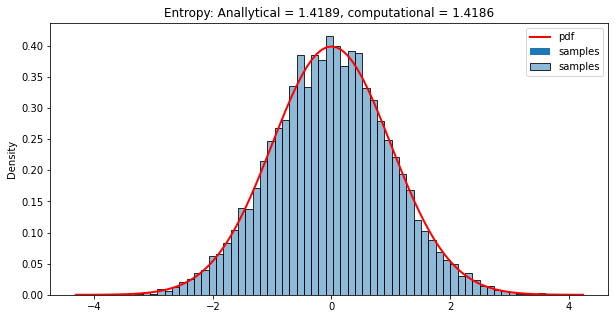

In [20]:
fig = plt.figure(figsize=(10,5))
ax = sns.histplot(x, kde=False, stat='density', label='samples')

# calculate the pdf
x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 100)
y_pdf = norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')                                                   
ax.legend()
ax.set_title('Entropy: Anallytical = ' + str(np.round(0.5*np.log(2*np.pi)+0.5,4)) + ', computational = ' + str(np.round(get_entropy_continuous(x,p=np.inf,k=10),4)))
plt.show()

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


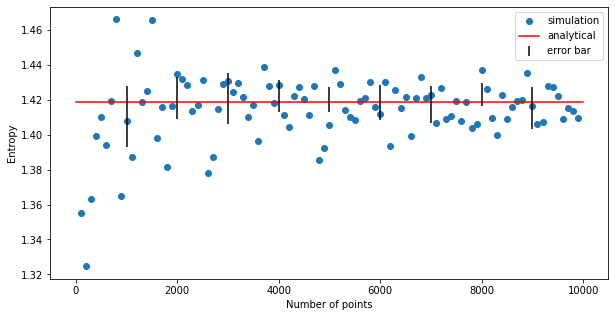

In [42]:
# Behavior of get_entropy_continuos as a function of the number of data points
lEntropyGaussian = []
lN = range(1,10000,100)
lEntropyError = []
lEntropyErrorBarr = []
lNError = []
for n in lN:
    x = np.random.normal(size=(n,1))
    lEntropyGaussian.append(get_entropy_continuous(x,p=np.inf,k=10))

    if (n - 1) % 1000 == 0:
        lEntropyErrorSim = []
        lNError.append(n)
        for _ in range(10):
            lEntropyErrorSim.append(get_entropy_continuous(np.random.normal(size=(n,1)),p=np.inf,k=10))
        lEntropyError.append(np.mean(lEntropyErrorSim))
        lEntropyErrorBarr.append(np.std(lEntropyErrorSim))
            
fig = plt.figure(figsize=(10,5))
#sns.scatterplot(lN, lEntropyGaussian)
plt.scatter(lN, lEntropyGaussian,label='simulation')
plt.plot([1,10000],[0.5*np.log(2*np.pi)+0.5,0.5*np.log(2*np.pi)+0.5],color='red',label='analytical')
plt.xlabel('Number of points')
plt.ylabel('Entropy')
#plt.ylim([0,1.5])
plt.errorbar(lNError, lEntropyError, yerr=lEntropyErrorBarr, xerr =None,color = 'k',ls='none',label='error bar')
plt.legend()
plt.show()

In [20]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]
NN = 50000
x, y = np.random.multivariate_normal(mean, cov, NN).T
get_mutual_information_mixed(x.reshape(NN,1),y.reshape(NN,1),p=np.inf,k=10)

-0.003553842521977008

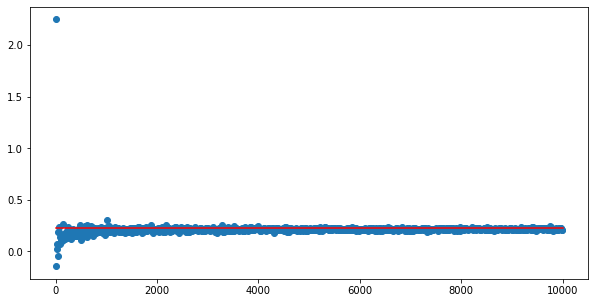

In [24]:
# Behavior of get_mutual_information_mixed as a function of the number of data points
lMutualInformationGaussian = []
lN = range(1,10000,10)
for NN in lN:
    mean = [0, 0]
    cov = [[1, 3./5], [3./5, 1]]
    x, y = np.random.multivariate_normal(mean, cov, NN).T
    lMutualInformationGaussian.append(get_mutual_information_mixed(x.reshape(NN,1),y.reshape(NN,1),p=np.inf,k=10))
fig = plt.figure(figsize=(10,5))
plt.scatter(lN, lMutualInformationGaussian)
plt.plot([1,10000],[-np.log(np.linalg.det(cov))/2,-np.log(np.linalg.det(cov))/2],color='red')
plt.show()